# Introduction

In this notebook, we train segmentation models on the preprocessed **Inria Aerial Image Labeling** dataset from `00b_inria_prepare_data.ipynb`. This is used as a pretext task for our MapAI models. 

https://project.inria.fr/aerialimagelabeling/

We will also use the model to provide labels on the mislabeled image-patches of the MapAI data in a later notebook.

# Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from datetime import date

In [3]:
from fastai.vision.all import *
from fastai_metrics import * 
from semantic_segmentation_augmentations.holemakerrandom import HoleMakerRandom
from semantic_segmentation_augmentations.cutmixrandom import CutMixRandom

In [4]:
#torch.cuda.set_device(1)

In [5]:
from constants import DATADIR, INRIA_DATA, INRIA_PATCHES

In [ ]:
PREDS = INRIA_PATCHES/'predictions'
PREDS.mkdir(exist_ok=True)

(PREDS/'val').mkdir(exist_ok=True)

# Load data

We load the INRIA dataset prepared by the notebook `00b_inria_prepare_data.ipynb`:

In [6]:
df = pd.read_csv('../csv/inria_aerial_image_dataset_train-2022-11-18.csv')
df.shape

(18000, 4)

In [7]:
df.head()

,image,mask,is_val,location
0,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_01.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_01.png,False,austin10
1,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_02.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_02.png,False,austin10
2,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_03.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_03.png,False,austin10
3,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_04.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_04.png,False,austin10
4,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/images/austin10_01_05.png,/home/ubuntu/data/mapai/external/inria_aerialimagelabeling/AerialImageDataset/train/png/gt/austin10_01_05.png,False,austin10


In [15]:
#for img in df.image.values:
#    try:
#        PILImage.create(img)
#    except:
#        print(f"Error in {img}?")

In [16]:
#for mask in df['mask'].values:
#    try:
#        PILImage.create(mask)
#    except:
#        print(f"Error in {mask}?")

# Define a validation set

In [8]:
df.location.unique()

array(['austin10', 'austin11', 'austin12', 'austin13', 'austin14',
       'austin15', 'austin16', 'austin17', 'austin18', 'austin19',
       'austin1', 'austin20', 'austin21', 'austin22', 'austin23',
       'austin24', 'austin25', 'austin26', 'austin27', 'austin28',
       'austin29', 'austin2', 'austin30', 'austin31', 'austin32',
       'austin33', 'austin34', 'austin35', 'austin36', 'austin3',
       'austin4', 'austin5', 'austin6', 'austin7', 'austin8', 'austin9',
       'chicago10', 'chicago11', 'chicago12', 'chicago13', 'chicago14',
       'chicago15', 'chicago16', 'chicago17', 'chicago18', 'chicago19',
       'chicago1', 'chicago20', 'chicago21', 'chicago22', 'chicago23',
       'chicago24', 'chicago25', 'chicago26', 'chicago27', 'chicago28',
       'chicago29', 'chicago2', 'chicago30', 'chicago31', 'chicago32',
       'chicago33', 'chicago34', 'chicago35', 'chicago36', 'chicago3',
       'chicago4', 'chicago5', 'chicago6', 'chicago7', 'chicago8',
       'chicago9', 'kitsap10', '

In [9]:
val_locs = ['austin1', 'kitsap16', 'tyrol-w5', 'vienna4']

In [10]:
df.loc[df.location.isin(val_locs), 'is_val'] = True

In [11]:
df.is_val.value_counts()

False    17600
True       400
Name: is_val, dtype: int64

# Inspect data

In [21]:
from plotting import plot_image_and_masks_from_df

In [20]:
from ipywidgets import interact, interactive, IntSlider, Select, RadioButtons, fixed, BoundedIntText

In [14]:
interactive_plot = interactive(plot_image_and_masks_from_df, df=fixed(df),
                               imgidx = BoundedIntText(min=0, max=len(df)-1, step=1, value=0),
                               figsize = BoundedIntText(min=4, max=12, step=1, value=6),
                               with_segm= RadioButtons(options=[True,False], value=True, 
                                                      description="With segmentation"))

output = interactive_plot.children[-1]

In [15]:
interactive_plot

interactive(children=(BoundedIntText(value=0, description='imgidx', max=17999), BoundedIntText(value=6, descri…

# Create dataloaders

In [12]:
models = [resnet34, resnet50, xresnet34, xresnet50, xresnet50_deep, xresnext50]
model_idx = 0 # Todo: resnet50, xresnet50, xresnext50

In [13]:
model_name = str(models[model_idx]).split(' ')[1]
model_name

'resnet34'

In [24]:
if '34' in model_name:
    rn=34
    bs=64
else:
    rn=50
    bs=32

In [25]:
bs

64

In [27]:
from training import get_batch_tfms, get_dataloaders, get_cbs

# Train models

In [28]:
from training import BinaryConverter

In [29]:
codes = [0,1]

We train our models using progressive resizing:

In [30]:
sz = (500,500)
half = tuple(int(x/2) for x in sz)

### 200 x 200

In [31]:
# item_tfms=[Resize(sz), BinaryConverter()] 
item_tfms=[BinaryConverter()] # Resize on GPU using randomcrops

In [32]:
batch_tfms = get_batch_tfms(normalize=Normalize.from_stats(*imagenet_stats), size=half)
# Test no imagenet normalization
#batch_tfms = get_batch_tfms(normalize=Normalize(), size=half)

In [33]:
dls = get_dataloaders(df, x_name='image', y_name='mask', codes=codes, 
                      splitter=ColSplitter('is_val'), 
                      bs=bs, item_tfms=item_tfms, 
                      batch_tfms=batch_tfms)

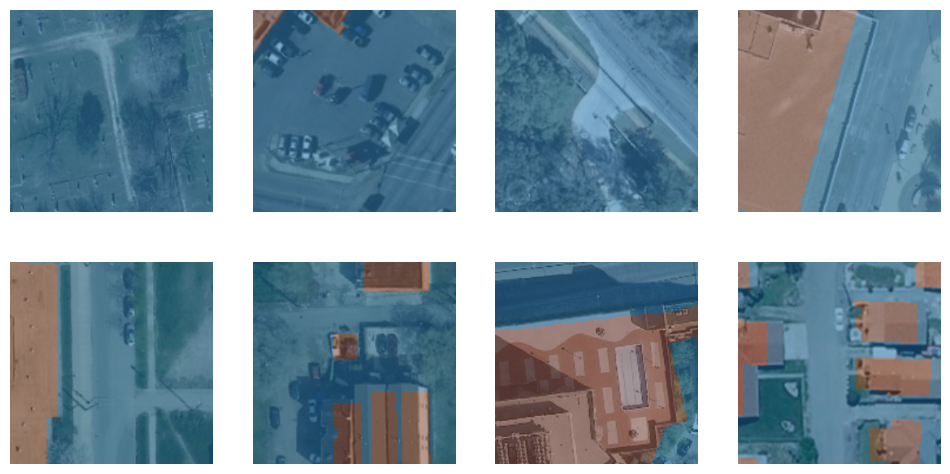

In [25]:
dls.show_batch(max_n=8)

In [34]:
#opt = ranger

In [35]:
metrics = [Dice, iou] #biou

In [36]:
#from loss_functions import CombinedCEFocalTverskyLoss
from loss_functions import CombinedFocalTanimotoLoss

In [37]:
#loss_func = FocalTverskyCrossEntropyLoss()
#loss_func = CombinedCEFocalTverskyLoss()
loss_func = CombinedFocalTanimotoLoss()
#loss_func=None

In [38]:
learn = unet_learner(dls, models[model_idx], loss_func=loss_func, metrics=metrics, 
                     self_attention=True).to_fp16()

/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/anaconda3/envs/mapai/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


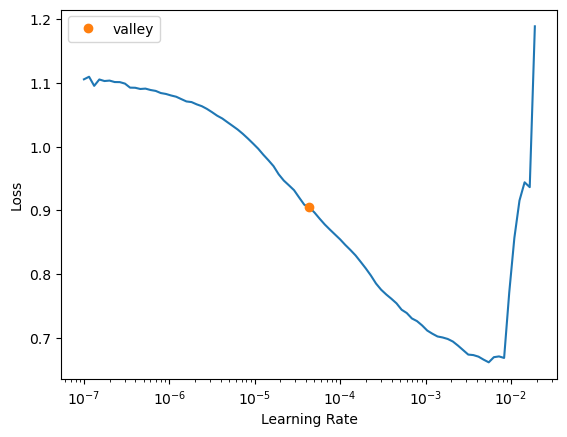

In [30]:
lr = learn.lr_find(end_lr=10e-2)
lr = lr.valley

In [31]:
lr

4.365158383734524e-05

In [40]:
hole_size = (100,100)
#save_fn = f'stage-1_{model_name}_pretraining-{model_name}-{date.today()}'

In [43]:
cbs = get_cbs(fname=save_fn, hole_size=hole_size, p=0.4)

In [44]:
learn.freeze()

epoch,train_loss,valid_loss,dice,iou,time
0,0.304491,0.259676,0.732726,0.723268,02:49


/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Better model found at epoch 0 with valid_loss value: 0.25967592000961304.


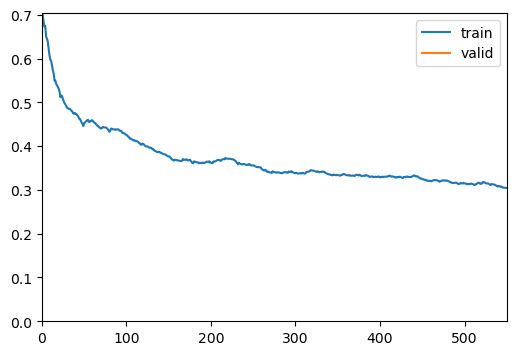

In [53]:
learn.fit_flat_cos(1, slice(lr), cbs=cbs) 

In [39]:
learn.load(save_fn)

In [ ]:
lrs = slice(lr/100, lr)
learn.unfreeze()

In [16]:
save_fn = f'stage-2_{model_name}_pretraining-{model_name}-{date.today()}'

epoch,train_loss,valid_loss,dice,iou,time
0,0.172487,0.127719,0.811120,0.779817,15:20
1,0.154031,0.116097,0.826626,0.792559,15:19


Better model found at epoch 0 with valid_loss value: 0.12771938741207123.


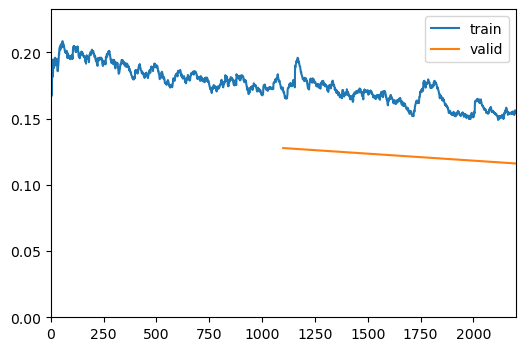

Better model found at epoch 1 with valid_loss value: 0.11609680205583572.


In [50]:
learn.fit_flat_cos(2, lrs, cbs=get_cbs(fname=save_fn, hole_size=hole_size)) 

In [38]:
learn.load(save_fn)

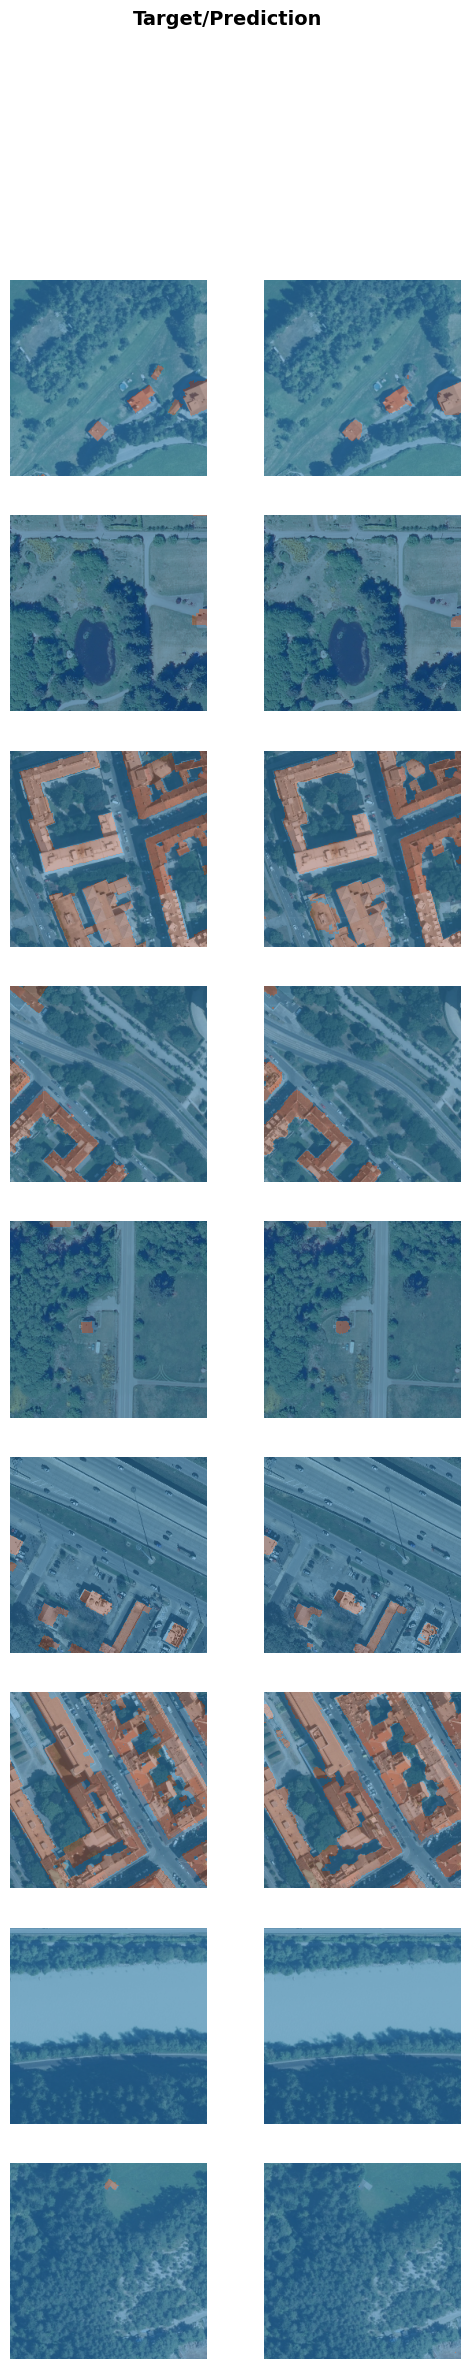

In [38]:
learn.show_results()

### 500 x 500

In [58]:
bs = int(bs/2)
bs

16

In [59]:
hole_size = (200,200)
batch_tfms = get_batch_tfms(normalize=Normalize.from_stats(*imagenet_stats), size=None)

In [60]:
learn.dls = get_dataloaders(df, x_name='image', y_name='mask', codes=codes, 
                      splitter=ColSplitter('is_val'), 
                      bs=bs, item_tfms=item_tfms, 
                      batch_tfms=batch_tfms)

In [61]:
lr

4.365158383734524e-05

In [63]:
save_fn = f'stage-3_{model_name}_pretraining-{model_name}-{date.today()}'

In [64]:
cbs = get_cbs(fname=save_fn, hole_size=hole_size, p=0.3)

epoch,train_loss,valid_loss,dice,iou,time
0,0.135227,0.086041,0.871682,0.838027,1:01:53


/home/alex/anaconda3/envs/mapai/lib/python3.10/site-packages/fastai/callback/core.py:69: UserWarning: You are shadowing an attribute (training) that exists in the learner. Use `self.learn.training` to avoid this
  warn(f"You are shadowing an attribute ({name}) that exists in the learner. Use `self.learn.{name}` to avoid this")


Better model found at epoch 0 with valid_loss value: 0.0860414057970047.


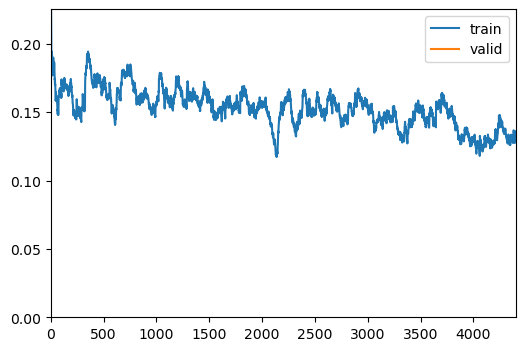

In [47]:
learn.fit_flat_cos(1, slice(lr), cbs=cbs)

In [66]:
lrs = slice(lr/200, lr/2)
learn.unfreeze()

In [67]:
save_fn = f'stage-4_{model_name}_pretraining-{model_name}-{date.today()}'

In [68]:
cbs = get_cbs(fname=save_fn, hole_size=hole_size, p=0.3)

epoch,train_loss,valid_loss,dice,iou,time
0,0.093575,0.068332,0.899909,0.869404,49:55
1,0.089822,0.061563,0.909363,0.878545,49:56
2,0.090017,0.062773,0.908096,0.875044,49:56
3,0.089482,0.062153,0.910654,0.880045,49:55
4,0.089217,0.060264,0.912029,0.881025,49:56


Better model found at epoch 0 with valid_loss value: 0.06833215057849884.


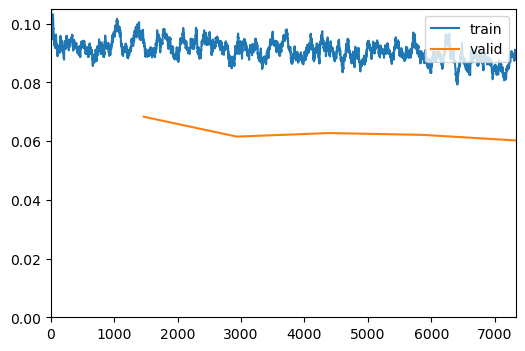

Better model found at epoch 1 with valid_loss value: 0.06156320497393608.
Better model found at epoch 4 with valid_loss value: 0.06026357784867287.


In [55]:
learn.fit_flat_cos(5, lrs, cbs=cbs) 

In [ ]:
learn.load(save_fn);